In [1]:
%matplotlib widget
from typing import Callable, Optional
from dataclasses import dataclass
from functools import partial
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.animation

In [2]:
from burgers import *
from bayes_1d_utils import func_inv, compute_posterior

# Bayesian Inference with PDEs

Here we will demonstrate how learning parameters of PDEs can be done via Bayesian inference.  Specifically, we will consider the Viscous Burgers' equation.

The viscous [Burgers'](https://en.wikipedia.org/wiki/Burgers'_equation) is a simplified model of the motion of a viscous compressible gas. It has the following parameters

- $x$: spatial variable
- $t$: time variable
- $u(t, x)$: speed of the gas at location $x$ and time $t$
- $\nu$: diffusion coefficient / kinematic viscocity

\begin{equation}
\frac{\partial}{\partial t}u(t, x) = - u(t, x) \frac{\partial}{\partial x} u(t,x) + \nu \frac{\partial^2}{\partial x^2} u(t, x)
\end{equation}

We will also add boundary conditions to this problem $u(t, 0) = u(t, 1) = 0,$ so that the domain of the problem is $x \in [0,1].$ We will also consider initial conditions that happen to be dependent on the viscosity

\begin{equation}
u(0, x) = 2 \nu \frac{\pi \sin(\pi  x)}{(1.0 + \cos(\pi x))}
\end{equation}

The diffusion coefficient is typically an uncertain positive number. While the viscous burgers has an analytic solution in some cases, it is a prototype for partial differential equations that can only be solved numerically. These can be quite expensive and so Monte Carlo methods are difficult to apply without dimension reduction. 

I have coded up a numerical solution to the Burgers' equation in the imported file `burgers.py` and will use that as the forward model.

## Learning task 

The learning task is to identify the viscocity $\nu$. Our data will consist of evaluations of $u(t, 0.75)$ at various times $t_1, t_2,\ldots, t_n).$ We will define this data as 

$$
d_i = u(t_i, 0.75)
$$

Lets create this data, assuming that the true parameter is $\nu = 0.75.$ 

Note that, for learning purposes, we are commiting an *inverse crime* in this notebook. We are learning using data from a "known true" model. In practice, data **never** comes from a known process and there is always some model error. If you design new approaches, you must demonstrate them in a regime where the process that generates the data is different from the model used to learn.

Let us first create some boilerplate to abstract away the numerical methods parameters so we don't have to worry about them later on.

In [3]:
@dataclass
class SimParams:
    x: np.ndarray = np.linspace(0, 1, 40)
    dx: float = x[1] - x[0]
    dt: float = 1e-4  # must be slow enough for stability
    num_steps: int = 10000
    t: np.ndarray = np.arange(0, num_steps * dt, dt)

@dataclass
class Solution:
    x: np.ndarray
    t: np.ndarray
    sol: np.ndarray

@dataclass
class Observation:
    ind_time_obs: np.ndarray
    ind_space_obs: int
    t_obs: np.ndarray
    y: np.ndarray

Next lets create the simulation and sensor functions. Each sensor value will be corrupted by noise *independently.*

In [4]:
sim_params = SimParams()
def simulate(viscosity: float) -> Solution:
    """Generate a solution for the velocity field for a given viscosity."""
    sol = solve(sim_params.dt,
                sim_params.dx,
                sim_params.num_steps,
                get_ic_dirichlet(sim_params.x, viscosity),
                viscosity)
    return Solution(sim_params.x, sim_params.t, sol)

def sensor(solution: Solution) -> Observation:
    """Sensor model that extracts data from the solution."""
    increment = 100
    ind_075 =  np.argmax(sim_params.x>=0.75)
    num_sol = solution.t.shape[0]
    ind_obs = np.arange(increment, num_sol, increment)  # don't observe initial condition
    t_obs = solution.t[ind_obs]
    y = solution.sol[ind_obs, ind_075]
    return Observation(ind_obs, ind_075, t_obs, y)

def generate_data(true_nu=0.75, noise_std=1.0):
    true_sim = simulate(true_nu)
    sensor_vals = sensor(true_sim)
    noise = noise_std * np.random.randn(sensor_vals.y.shape[0])
    sensor_vals.y += noise
    return true_sim, sensor_vals

In [5]:
true_sim, data = generate_data(noise_std=1.0)

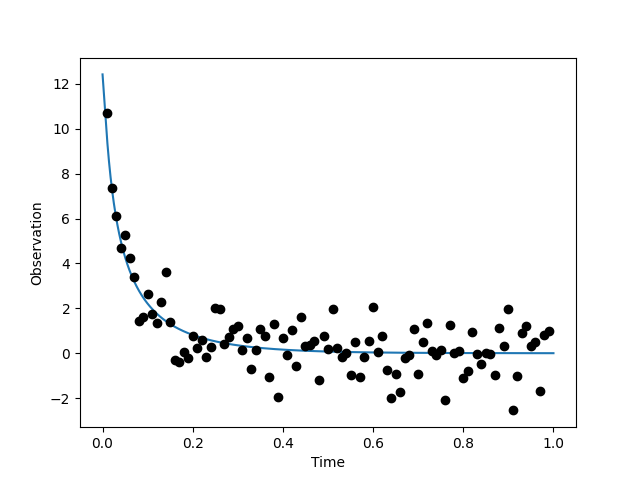

In [6]:
plt.close(1)
plt.figure(1)
plt.plot(true_sim.t, true_sim.sol[:, data.ind_space_obs], '-')
plt.plot(data.t_obs, data.y, 'ko')
plt.xlabel('Time')
plt.ylabel('Observation')
plt.show()

## Bayesian inference

Now that we have the data, let us set up the learning problem. For the prior, we will use a uniform distribution on $[0.1, 0.9]$, (because the solver seems to be robust for that range). For the likelihood we will assume that the sensor value at each time is corrupted with noise independently, just as the data was generated. 

In [7]:
def uniform_prior(params: np.ndarray) -> np.ndarray:
    out = np.zeros(params.shape[0])

    inds = np.where((params > 0.1) & (params < 0.9))
    out[inds] =  1.0 / 0.8
    return out

class Model:
    """Model that derives the likelihood."""

    def __init__(self, noise_std):
        self.noise_std = noise_std

    def likelihood(self, data, param):
        """(Unnormalized) Likelihood of the data."""

        model_prediction = simulate(param)
        sensor_prediction = sensor(model_prediction)

        log_like = - 0.5 * np.linalg.norm(sensor_prediction.y - data.y)**2 / self.noise_std**2
        return np.exp(log_like)

Next lets compute the posterior

In [8]:
model = Model(1e0)
params_discretized = np.linspace(0.1, 0.9, 100)
posterior = compute_posterior(data, model, uniform_prior, params_discretized)

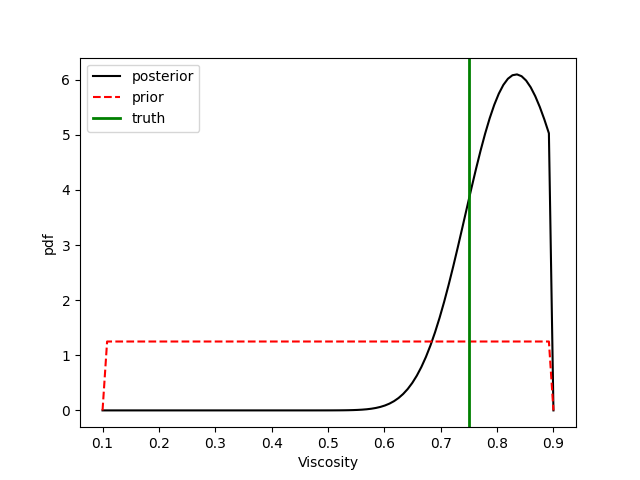

In [9]:
plt.close(2)
plt.figure(2)
plt.plot(params_discretized, posterior, '-k', label='posterior')
plt.plot(params_discretized, uniform_prior(params_discretized), '--r', label='prior')
plt.axvline(x=0.75, color='green', linewidth=2, label='truth')
plt.xlabel('Viscosity')
plt.ylabel('pdf')
plt.legend()
plt.show()

### Prior and posterior predictives

One thing that is useful to look at is not only the prior and posterior pdfs, but also the uncertainty in the predictions themselves. In our study of Monte Carlo, we essentially propagated the prior forward. Lets take a look at the resulting prediction here, prior to inference.

In [10]:
num_samples = 50
prior_pred_samples = [simulate(np.random.rand(1)*0.8 + 0.1) for ii in range(num_samples)]

Now we need to generate samples of the posterior. Here we notice a problem, we do not have a way to sample from the PDF, even though we have an expression for the PDF at a coarsely discretized set of points. We could use importance sampling here, and we will learn another approach (Markov Chain Monte Carlo) for how to generate samples when we can only evaluate the (unnormalized PDF). For now, we will make an approximation using the numerical representation of the PDF to compute an empirical CDF and then perform inverse CDF sampling.

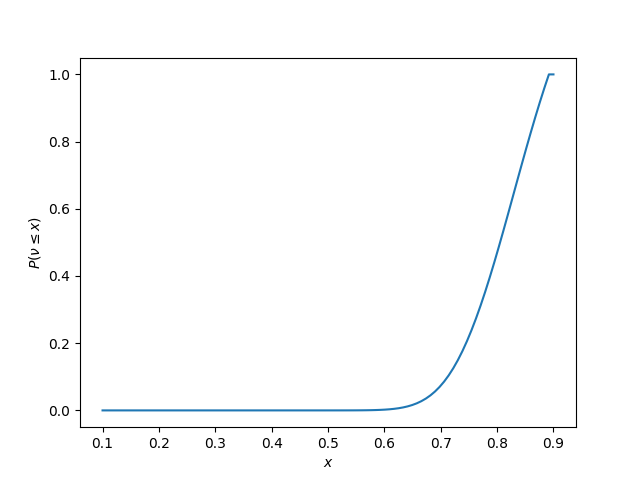

In [11]:
posterior_cdf = np.cumsum(posterior) * (params_discretized[1] - params_discretized[0])
plt.close(3)
plt.figure(3)
plt.plot(params_discretized, posterior_cdf)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(\nu \leq x)$')
plt.show()

In [12]:
def inverse_cdf_sample(num_samples: int) -> np.ndarray:
    """Performan inverse cdf sampling"""
    return func_inv(params_discretized, posterior_cdf, np.random.rand(num_samples))

post_samples = inverse_cdf_sample(num_samples)
post_pred_samples = [simulate(p) for p in post_samples]

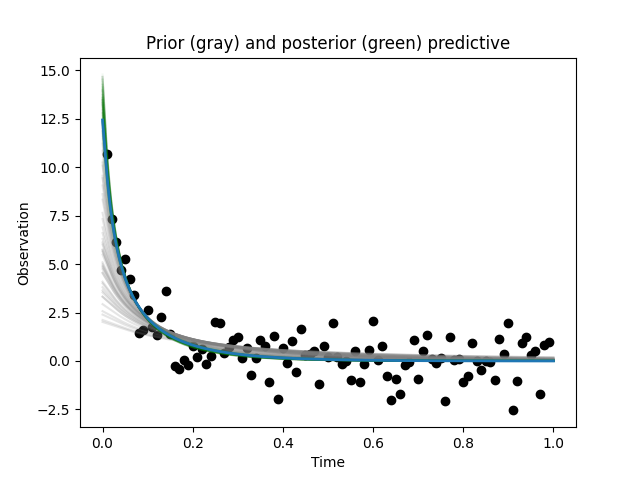

In [13]:
plt.close(4)
plt.figure(4)
plt.plot(data.t_obs, data.y, 'ko')
for prior_samp in prior_pred_samples:
    plt.plot(prior_samp.t, prior_samp.sol[:, data.ind_space_obs], color='gray', alpha=0.2)
for post_samp in post_pred_samples:
    plt.plot(post_samp.t, post_samp.sol[:, data.ind_space_obs], color='green', alpha=0.05)
plt.plot(true_sim.t, true_sim.sol[:, data.ind_space_obs], '-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Observation')
plt.title("Prior (gray) and posterior (green) predictive")
plt.show()